# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`IsFraudulent`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from itertools import combinations
from scipy.stats import chi2_contingency
# Otros objetivos
# -----------------------------------------------------------------------
import math
# Funciones
import sys
sys.path.append('../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_logistica_preprocesamiento as slp
import src.soporte_encoding as se

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Estandarización
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

# Encoding
from category_encoders import TargetEncoder

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Outliers
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors 

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('datos\\financial_data.csv')
# llamar a DF 

In [3]:
df.head()
# conocer sus datos

transaction_id  customer_id  merchant_id   amount     transaction_time  \
0               1         1082         2027  5758.59  2023-01-01 00:00:00   
1               2         1015         2053  1901.56  2023-01-01 00:00:01   
2               3         1004         2035  1248.86  2023-01-01 00:00:02   
3               4         1095         2037  7619.05  2023-01-01 00:00:03   
4               5         1036         2083  1890.10  2023-01-01 00:00:04   

   is_fraudulent   card_type location purchase_category  customer_age  \
0              0  MasterCard  City-30       Gas Station            43   
1              1        Visa  City-47   Online Shopping            61   
2              1  MasterCard   City-6       Gas Station            57   
3              1    Discover   City-6            Travel            59   
4              1  MasterCard  City-34            Retail            36   

     transaction_description  
0  Purchase at Merchant-2027  
1  Purchase at Merchant-2053  
2  Purchase at Merchant-2035  
3  Purchase at Merchant-2037  
4  Purchase at Merchant-2083

In [4]:
df.info()
# comprobar tipos y nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [5]:
df.nunique()
# ver las categrías distintas para cada columna

transaction_id             10000
customer_id                  100
merchant_id                  100
amount                      9945
transaction_time           10000
is_fraudulent                  2
card_type                      4
location                      50
purchase_category              6
customer_age                  53
transaction_description      100
dtype: int64

In [6]:
f.exploracion_dataframe(df, 'is_fraudulent')
# conocer mis columnas

El número de datos es 10000 y el de columnas es 11

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


Empty DataFrame
Columns: [%_nulos]
Index: []


 ..................... 

Los tipos de las columnas son:


tipo_dato
transaction_id              int64
customer_id                 int64
merchant_id                 int64
amount                    float64
transaction_time           object
is_fraudulent               int64
card_type                  object
location                   object
purchase_category          object
customer_age                int64
transaction_description    object


 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna transaction_time tiene las siguientes valore únicos:


count
transaction_time          
2023-01-01 00:00:00      1
2023-01-01 01:51:10      1
2023-01-01 01:51:03      1
2023-01-01 01:51:04      1
2023-01-01 01:51:05      1
...                    ...
2023-01-01 00:55:33      1
2023-01-01 00:55:34      1
2023-01-01 00:55:35      1
2023-01-01 00:55:36      1
2023-01-01 02:46:39      1

[10000 rows x 1 columns]

La columna card_type tiene las siguientes valore únicos:


count
card_type              
Discover           2633
American Express   2494
Visa               2490
MasterCard         2383

La columna location tiene las siguientes valore únicos:


count
location       
City-7      223
City-40     221
City-41     218
City-14     218
City-32     218
City-24     217
City-20     215
City-22     213
City-4      213
City-45     211
City-43     210
City-5      210
City-13     209
City-39     209
City-12     209
City-23     209
City-37     209
City-25     207
City-28     207
City-42     206
City-47     206
City-17     205
City-48     202
City-50     202
City-49     202
City-19     201
City-9      200
City-11     199
City-29     197
City-46     196
City-33     196
City-3      195
City-10     194
City-18     194
City-26     192
City-30     191
City-21     191
City-27     191
City-38     191
City-34     191
City-6      190
City-44     189
City-1      188
City-8      188
City-16     186
City-2      185
City-15     184
City-31     177
City-36     167
City-35     158

La columna purchase_category tiene las siguientes valore únicos:


count
purchase_category       
Travel              1694
Groceries           1692
Gas Station         1666
Retail              1661
Online Shopping     1651
Restaurant          1636

La columna transaction_description tiene las siguientes valore únicos:


count
transaction_description         
Purchase at Merchant-2016    120
Purchase at Merchant-2078    120
Purchase at Merchant-2055    118
Purchase at Merchant-2013    117
Purchase at Merchant-2057    117
...                          ...
Purchase at Merchant-2033     82
Purchase at Merchant-2045     82
Purchase at Merchant-2031     80
Purchase at Merchant-2070     75
Purchase at Merchant-2100     75

[100 rows x 1 columns]

In [7]:
df.describe().T

count         mean          std      min       25%  \
transaction_id  10000.0  5000.500000  2886.895680     1.00  2500.750   
customer_id     10000.0  1051.272300    28.864062  1001.00  1026.000   
merchant_id     10000.0  2050.486600    28.877801  2001.00  2025.000   
amount          10000.0  4958.381617  2899.699675    10.61  2438.175   
is_fraudulent   10000.0     0.506800     0.499979     0.00     0.000   
customer_age    10000.0    44.047500    15.321707    18.00    31.000   

                     50%        75%       max  
transaction_id  5000.500  7500.2500  10000.00  
customer_id     1052.000  1076.0000   1100.00  
merchant_id     2050.000  2076.0000   2100.00  
amount          4943.945  7499.3125   9999.75  
is_fraudulent      1.000     1.0000      1.00  
customer_age      44.000    57.0000     70.00

In [8]:
df.describe(include='O').T

count unique                        top  freq
transaction_time         10000  10000        2023-01-01 00:00:00     1
card_type                10000      4                   Discover  2633
location                 10000     50                     City-7   223
purchase_category        10000      6                     Travel  1694
transaction_description  10000    100  Purchase at Merchant-2016   120

In [9]:
df['card_type'].value_counts()

card_type
Discover            2633
American Express    2494
Visa                2490
MasterCard          2383
Name: count, dtype: int64

# Observaciones:

- No hay nulos.
- No hay duplicados.
- Para las numéricas: 
    - Tenemos una media de edad de 44 años, con un mínimo de 18 y un máximo de 70.
    - Un monto promedio de 4958, con un mínimo de 10 y un máximo de 9999.
    - Existen otras numéricas que son más lógicas de tratar como categóricas como los ID.
    - is_fraudulent se queda como binaria.
Para las categóricas:
    - La tarjeta con más apariciones fue Discover.
    La ubicación donde más compra se hicieron cargos fue City-7
    - La categoría de compra con más presencia fue Travel.

- Es importante comentar que al no tener nulos, no hay que imputar nada.

In [10]:
df = df.drop(columns= ['transaction_description', 'transaction_time'])

Me voy a cargar estas dos columnas, la description solo me aporta el lugar que ya lo tengo indicado y la fecha de momento no es mi prioridad.

In [11]:
df['is_fraudulent'].value_counts(normalize=True) * 100

is_fraudulent
1    50.68
0    49.32
Name: proportion, dtype: float64

In [12]:
df_num, df_cat = f.separar_dataframe(df)

# Visualizaciones

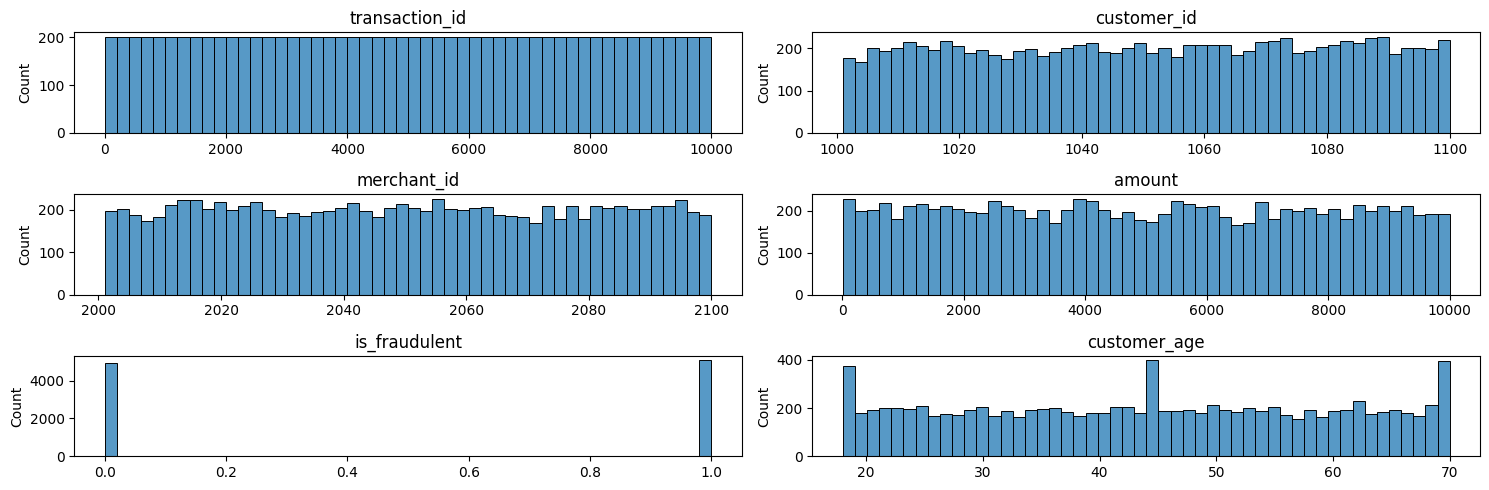

In [13]:
f.plot_numericas(df_num)

Después de haber hecho algunos cambios en mis tipos de columnas, solo me quedo con dos variables categóricas ( amount, customer_age).
- En cuanto al monto, no hay ningún pico como tal.
- Customer age tiene tres picos, uno en el mínimo, otro en el máximo y otro en lo que aparenta ser la mediana.

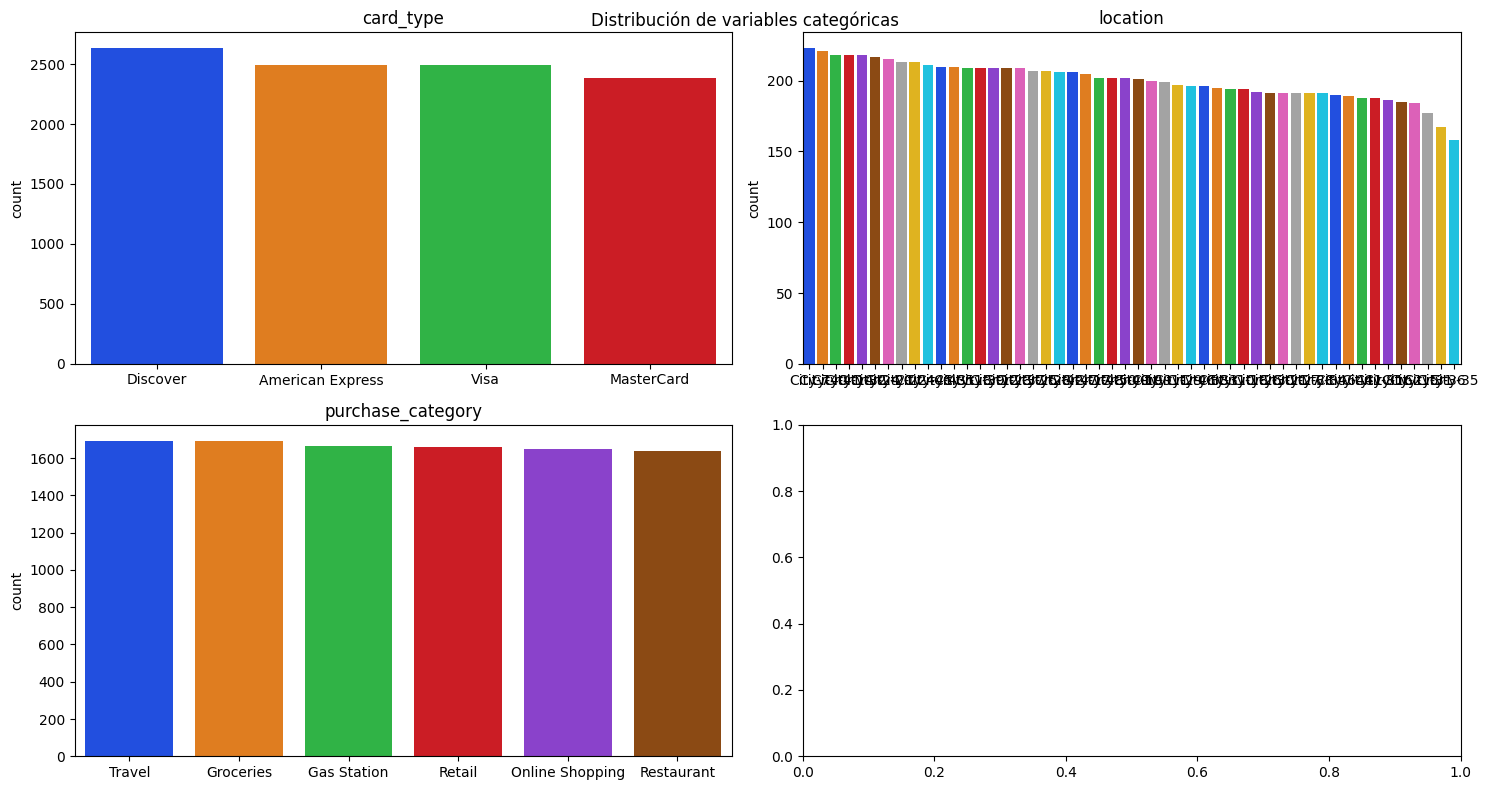

In [14]:
f.plot_categoricas(df_cat)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   customer_id        10000 non-null  int64  
 2   merchant_id        10000 non-null  int64  
 3   amount             10000 non-null  float64
 4   is_fraudulent      10000 non-null  int64  
 5   card_type          10000 non-null  object 
 6   location           10000 non-null  object 
 7   purchase_category  10000 non-null  object 
 8   customer_age       10000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 703.3+ KB


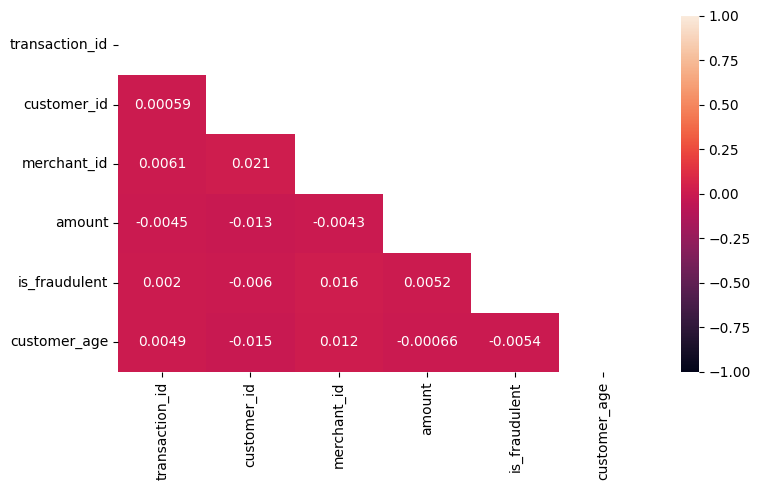

In [16]:
f.matriz_correacion(df)

Entre las variables numéricas no hay correlación.

In [17]:
df['transaction_id'] = df['transaction_id'].astype('category')
df['customer_id'] = df['customer_id'].astype('category')
df['merchant_id'] = df['merchant_id'].astype('category')
df['is_fraudulent'] = df['is_fraudulent'].astype('category')

## Relaciones categóricas con variable respuesta

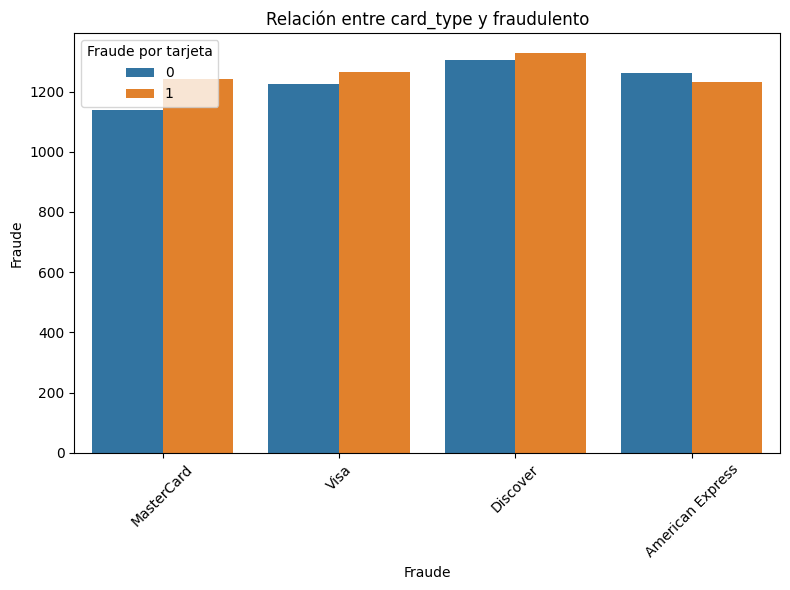

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='card_type', hue='is_fraudulent')
plt.title('Relación entre card_type y fraudulento')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por tarjeta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No se ven diferencia evidentes entre sí o no por la tarjeta usada. Sin embargo, en todos los casos hay más transacciones fraudulentas que no. Aunque visualmente, la MasterCard es la que tienes menos casos.

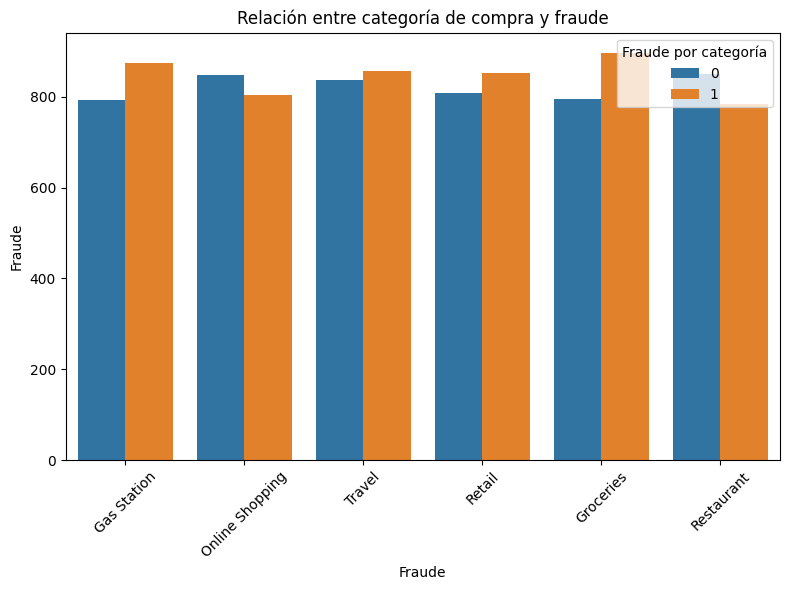

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='purchase_category', hue='is_fraudulent')
plt.title('Relación entre categoría de compra y fraude')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por categoría')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Observaciones: 
    -Hay 4 grupos donde el fraude predomina a simple vista:
    (gas station, travel, retail, groceries)
    - En los demás grupos (online shopping y restaurant) hay menos presencia de fraude.

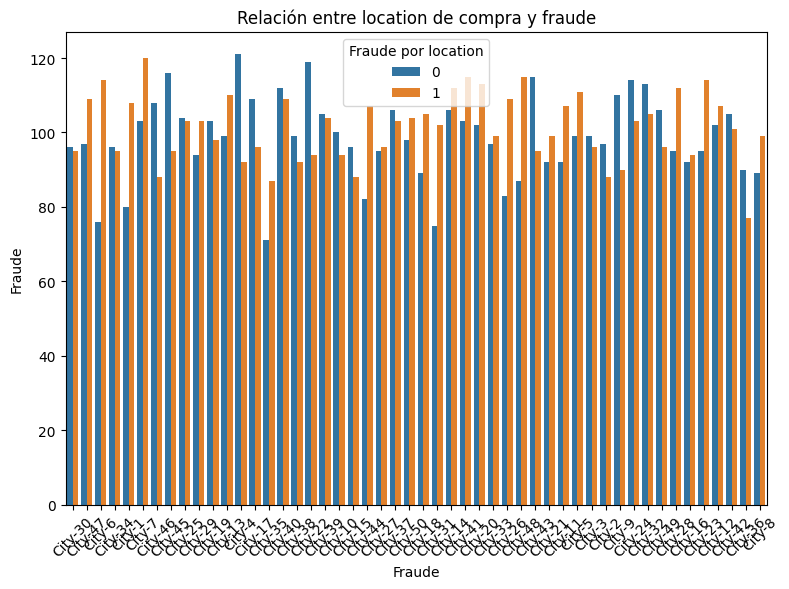

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='location', hue='is_fraudulent')
plt.title('Relación entre location de compra y fraude')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Para el location, no hay nada muy claro que señalar.

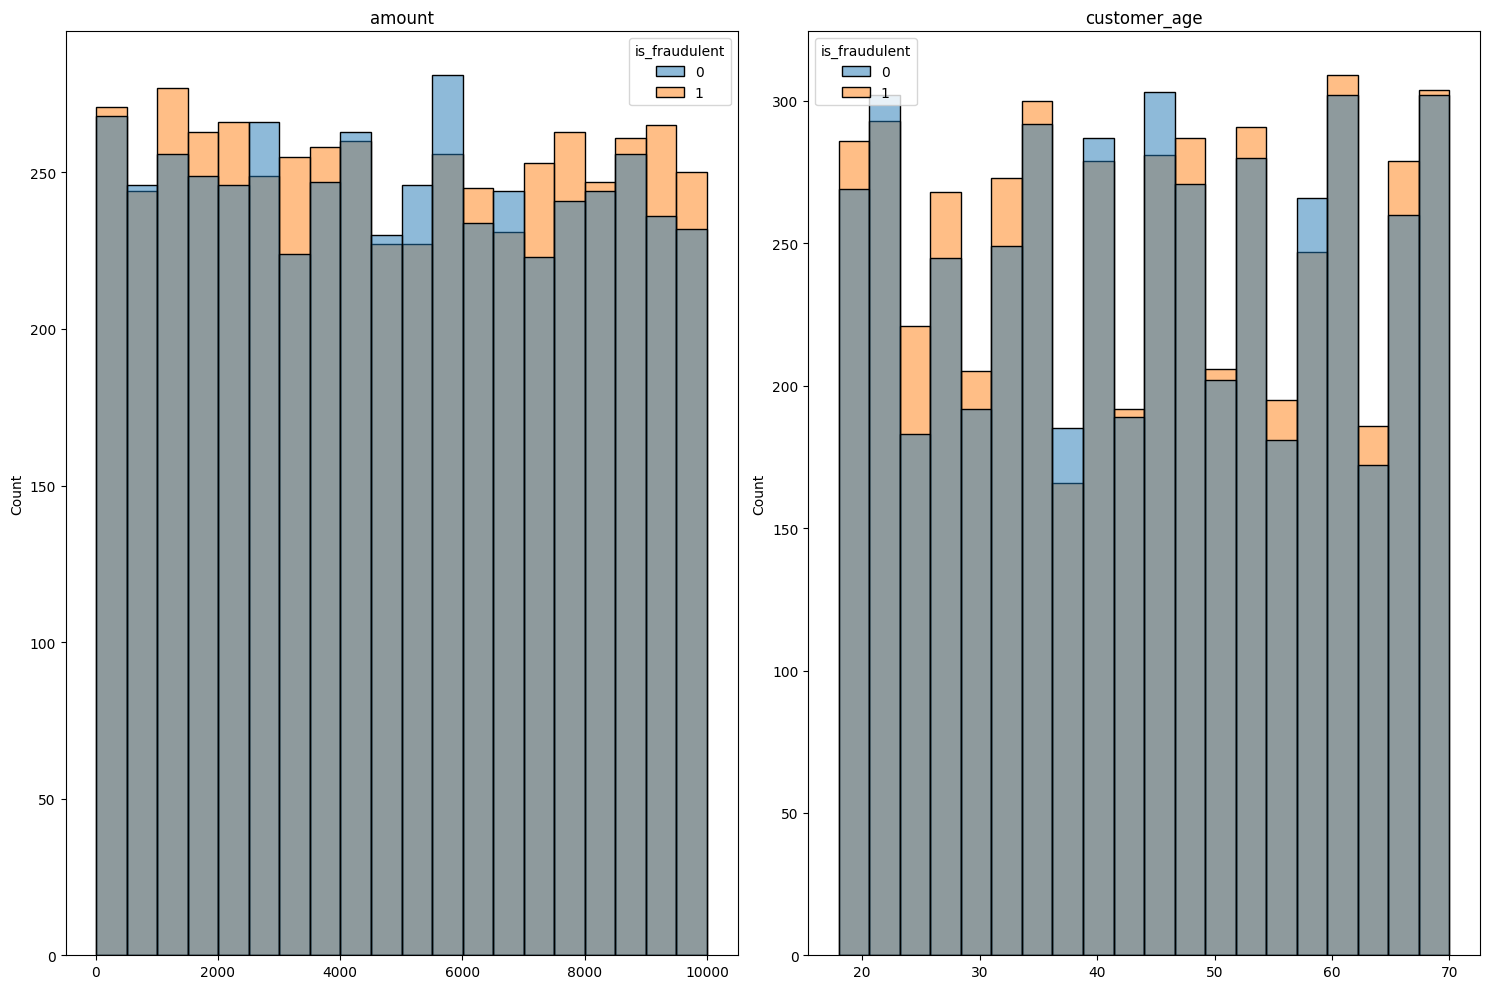

In [21]:
f.relacion_vr_numericas_problema_categorico(df,'is_fraudulent')

- No es algo muy evidente a la hora de visualizar si hay fraude respecto a monto, pero sí se puede observar que por debajo de los 4000 y por encima de 6000 es que se evidencian un poco más de fraudes.

- En cuanto a la edad, se cometen fraudes en todas las edades. No hay diferencia aparente.

# Outliers

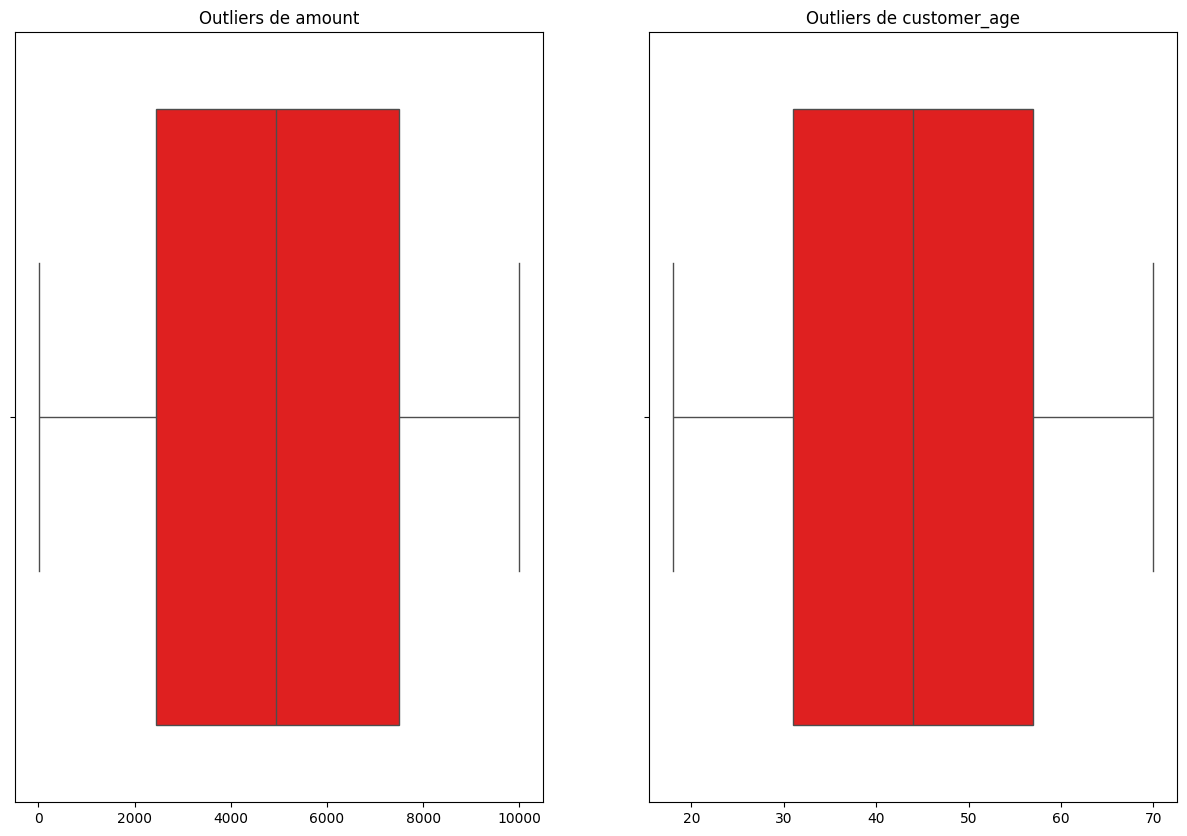

In [22]:
f.detectar_outliers(df)

<Axes: xlabel='amount', ylabel='customer_age'>

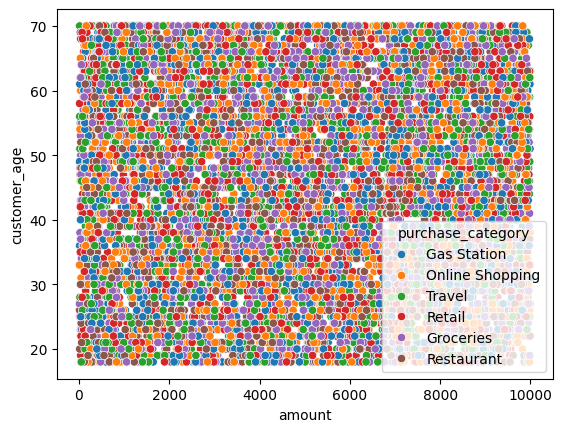

In [23]:
sns.scatterplot(x='amount', y='customer_age', hue='purchase_category', data=df)

In [24]:
cols_numericas = df.select_dtypes(include=np.number).columns

In [25]:
diccionario_resultados_outliers = f.identificar_outliers_iqr(df, cols_numericas)

La columna AMOUNT tiene 0 outliers
La columna CUSTOMER_AGE tiene 0 outliers


No se identifican outliers de manera clara con el método IQR. Veamos si encontramos algo con el método de multivariados.

# Outliers Multivariados

In [26]:
contaminacion = [0.01, 0.05, 0.1]
estimadores = [100, 500, 1000]

combinaciones = list(product(contaminacion, estimadores))
combinaciones

[(0.01, 100),
 (0.01, 500),
 (0.01, 1000),
 (0.05, 100),
 (0.05, 500),
 (0.05, 1000),
 (0.1, 100),
 (0.1, 500),
 (0.1, 1000)]

In [27]:
for cont, esti in tqdm(combinaciones):
    ifo = IsolationForest(random_state=42, #semilla de datos aleatorios
                        n_estimators=esti, #numero de arboles
                        contamination=cont,
                        n_jobs=-1) #nucleos del ordenador

    df[f'outliers_ifo_{cont}_{esti}'] = ifo.fit_predict(df[['amount', 'customer_age']])

100%|██████████| 9/9 [00:36<00:00,  4.03s/it]


In [28]:
columnas_ifo = df.filter(like='outlier').columns # se queda con todas las columnas de out
columnas_ifo

Index(['outliers_ifo_0.01_100', 'outliers_ifo_0.01_500',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_500', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_500',
       'outliers_ifo_0.1_1000'],
      dtype='object')

In [29]:
combinaciones_viz = list(combinations(['amount', 'customer_age'], 2)) # hago combinaciones de 2
combinaciones_viz

[('amount', 'customer_age')]

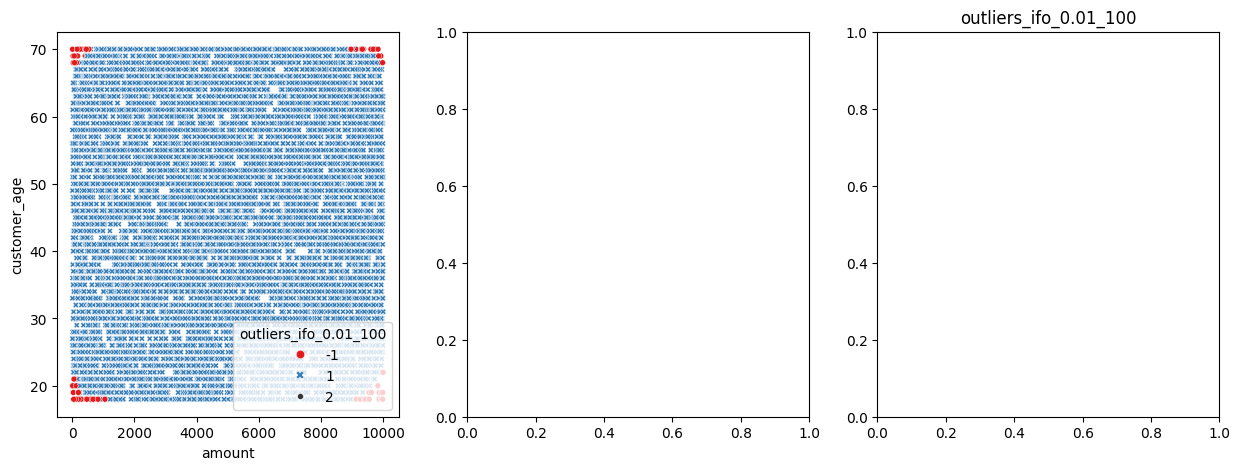

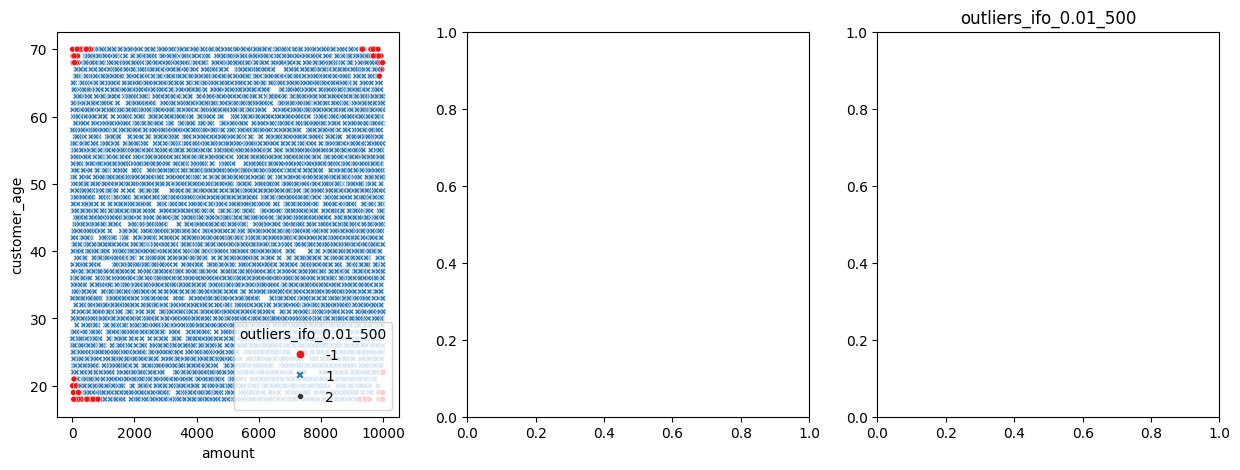

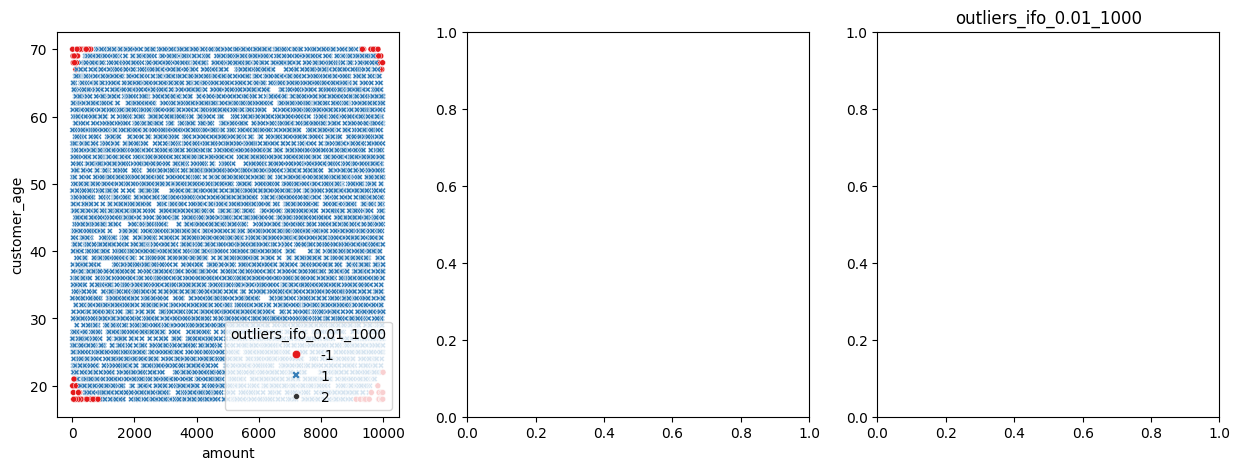

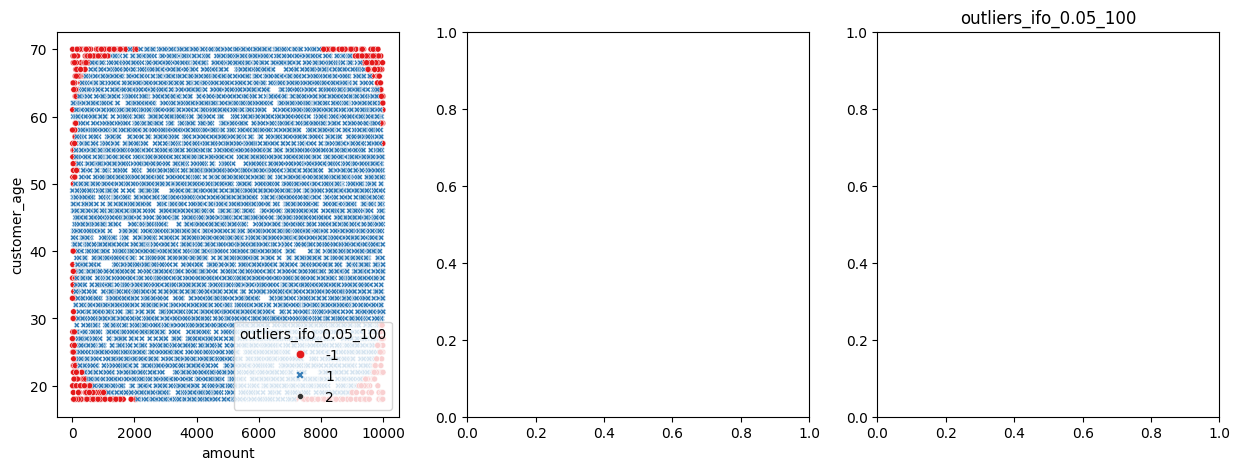

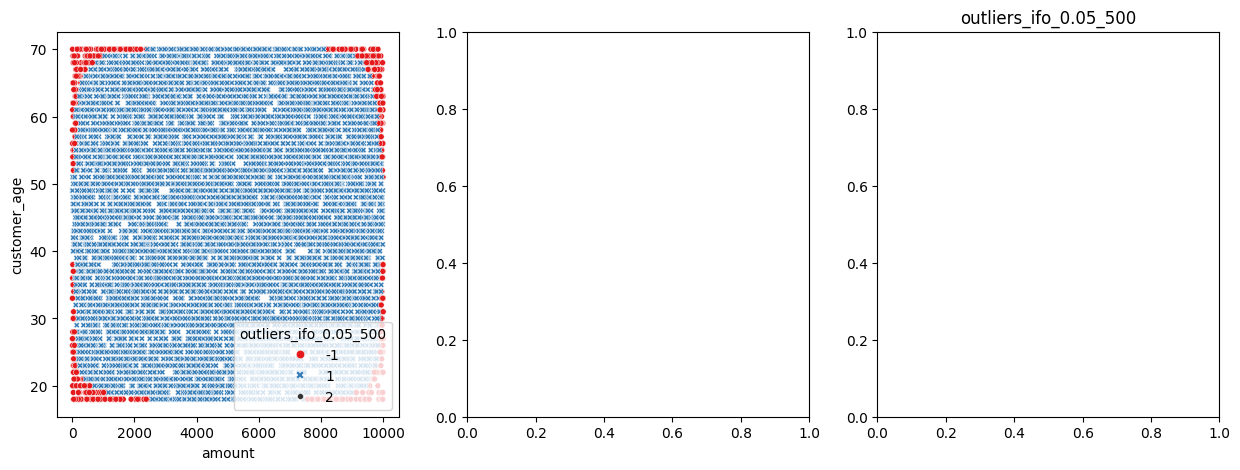

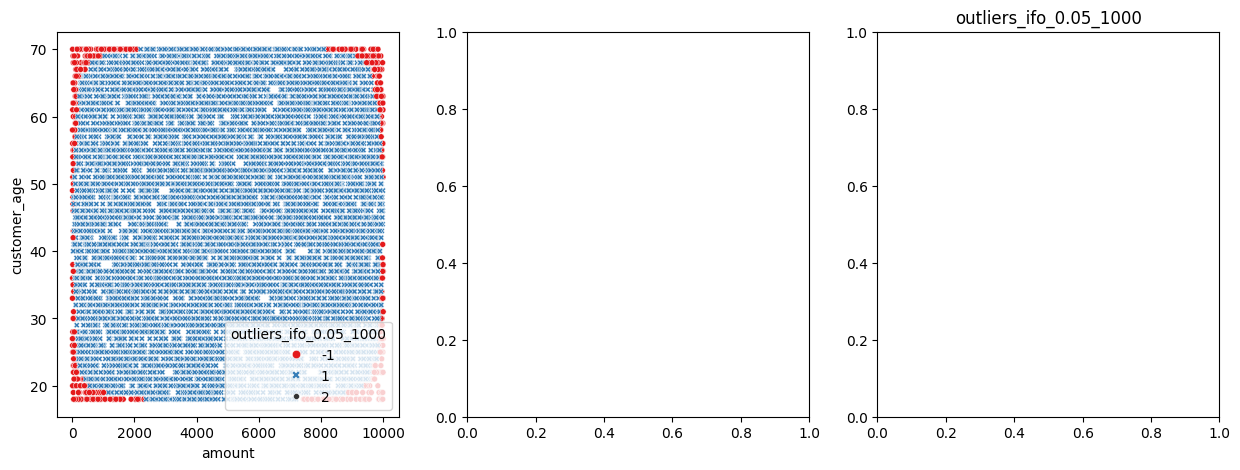

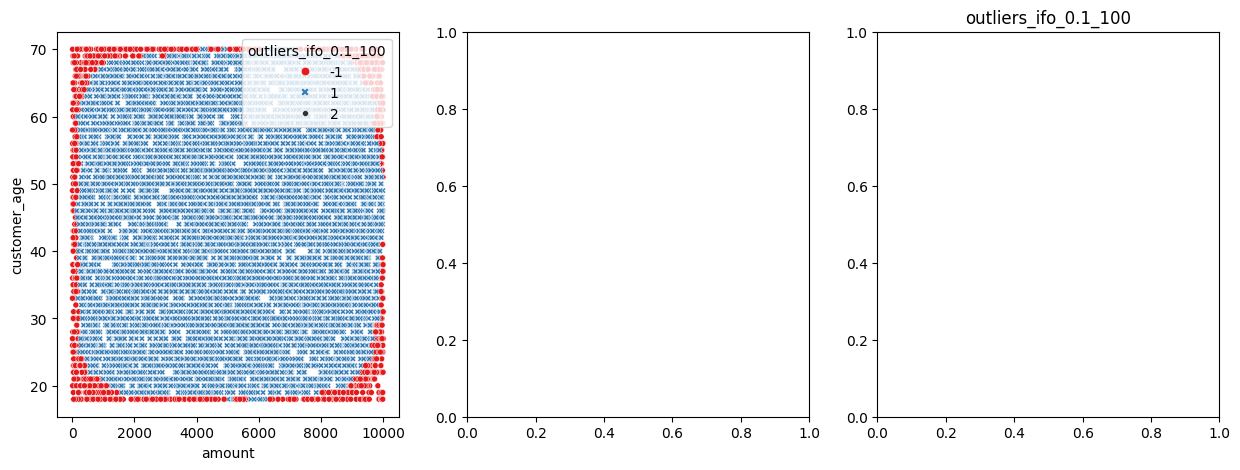

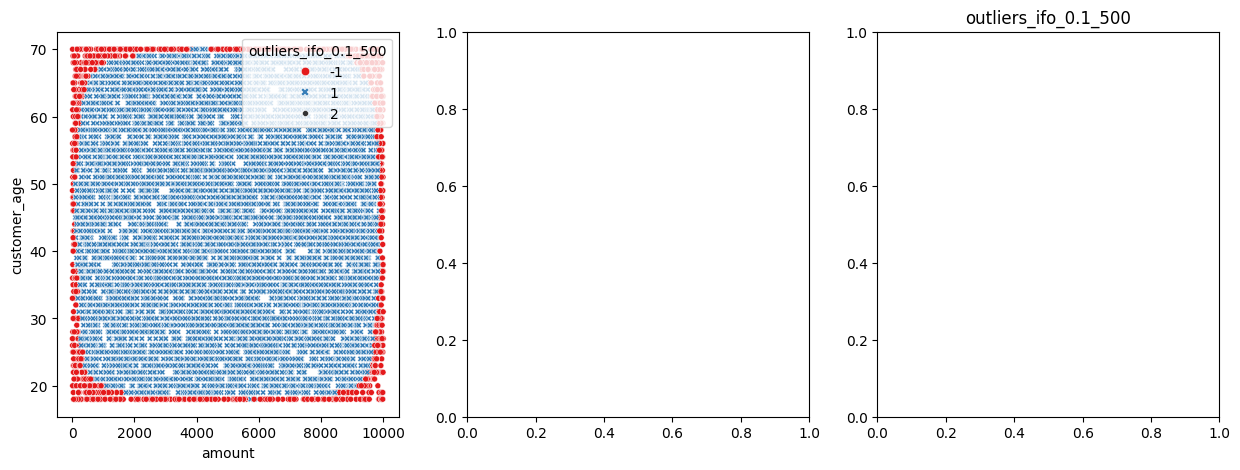

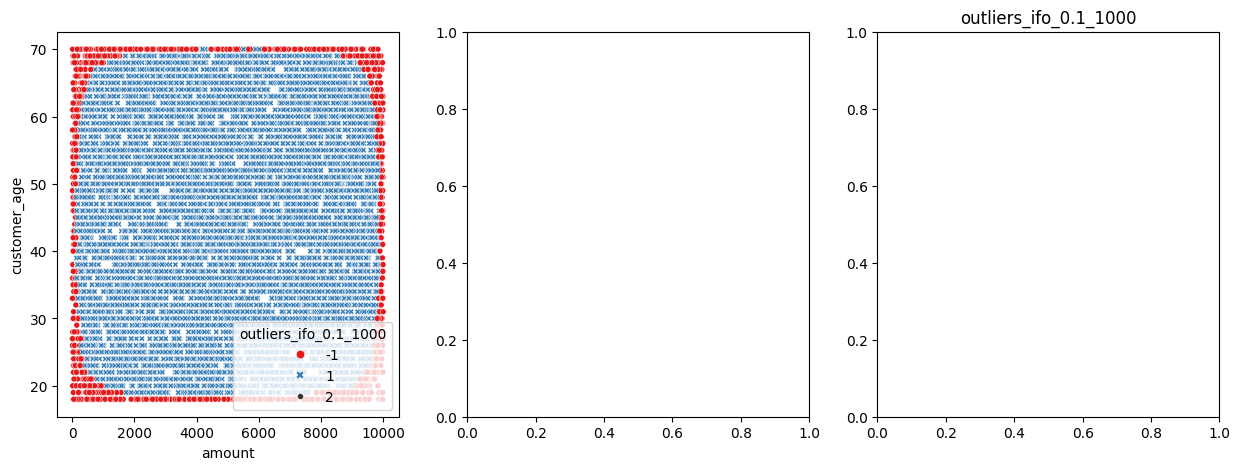

In [30]:
for outlier in columnas_ifo:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x=tupla[0],
                        y=tupla[1], 
                        ax=axes[indice],
                        data=df,
                        style=outlier,
                        size=2,
                        hue=outlier, #aqui miro todos mis graficos para ver cual me muestra los mejores OUTL
                        palette='Set1')
        
    plt.title(f'{outlier}')

In [31]:
filtered_df = df[(df[columnas_ifo] == -1).all(axis=1)]

Tenemos identificados 85 casos donde se presenta que en todos los casos son outliers. Aquí, sin embargo, no hay una diferencia clara entre aquellas que fueron o no fradulenta ya que la observacoón más clara está en la edad: ambos casos se presentan para los más jóvenes y más mayores, sin importar que su cargo sea o no fradulento.

Esto me lleva a pensar que puede haber algunos que de por sí son erroneos y otros que son outliers claros.

In [32]:
filtered_df

transaction_id customer_id merchant_id   amount is_fraudulent  \
295             296        1084        2061  9677.67             0   
345             346        1063        2012   544.84             0   
367             368        1024        2041   153.30             1   
621             622        1057        2084  9708.95             1   
655             656        1074        2084  9898.77             1   
...             ...         ...         ...      ...           ...   
9183           9184        1038        2012   672.43             0   
9385           9386        1001        2068   832.49             0   
9402           9403        1063        2064  9984.35             0   
9429           9430        1032        2086  9328.91             0   
9794           9795        1049        2032   200.80             1   

             card_type location purchase_category  customer_age  \
295           Discover  City-31   Online Shopping            70   
345   American Express  City-13         Groceries            70   
367               Visa  City-21       Gas Station            70   
621         MasterCard  City-18            Retail            70   
655   American Express  City-13   Online Shopping            69   
...                ...      ...               ...           ...   
9183              Visa  City-15        Restaurant            18   
9385        MasterCard  City-40   Online Shopping            18   
9402  American Express  City-28         Groceries            19   
9429  American Express  City-24            Retail            70   
9794              Visa   City-5        Restaurant            19   

      outliers_ifo_0.01_100  outliers_ifo_0.01_500  outliers_ifo_0.01_1000  \
295                      -1                     -1                      -1   
345                      -1                     -1                      -1   
367                      -1                     -1                      -1   
621                      -1                     -1                      -1   
655                      -1                     -1                      -1   
...                     ...                    ...                     ...   
9183                     -1                     -1                      -1   
9385                     -1                     -1                      -1   
9402                     -1                     -1                      -1   
9429                     -1                     -1                      -1   
9794                     -1                     -1                      -1   

      outliers_ifo_0.05_100  outliers_ifo_0.05_500  outliers_ifo_0.05_1000  \
295                      -1                     -1                      -1   
345                      -1                     -1                      -1   
367                      -1                     -1                      -1   
621                      -1                     -1                      -1   
655                      -1                     -1                      -1   
...                     ...                    ...                     ...   
9183                     -1                     -1                      -1   
9385                     -1                     -1                      -1   
9402                     -1                     -1                      -1   
9429                     -1                     -1                      -1   
9794                     -1                     -1                      -1   

      outliers_ifo_0.1_100  outliers_ifo_0.1_500  outliers_ifo_0.1_1000  
295                     -1                    -1                     -1  
345                     -1                    -1                     -1  
367                     -1                    -1                     -1  
621                     -1                    -1                     -1  
655                     -1                    -1                     -1  
...                    ...               

<Axes: xlabel='amount'>

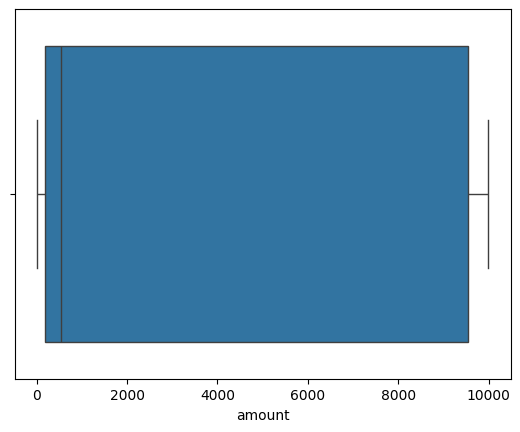

In [33]:
sns.boxplot(x='amount', data=filtered_df)

<Axes: xlabel='customer_age'>

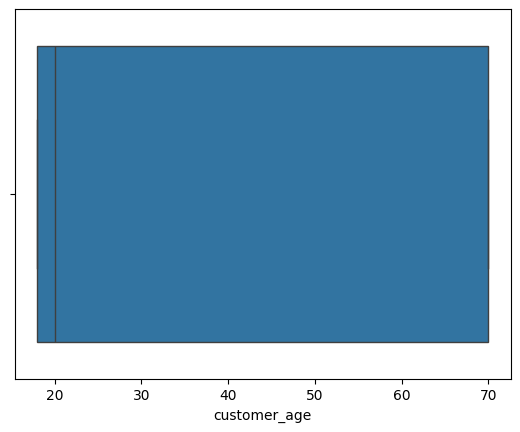

In [34]:
sns.boxplot(x='customer_age', data=filtered_df)

Se puede apreciar una alta concentración de gastos con muy poco valor, por lo que se presenta un sesgo a la derecha de mi boxplot. Tampoco hay outliers como tal.

In [35]:
filtered_df['purchase_category'].value_counts(normalize=True) * 100

purchase_category
Retail             23.529412
Online Shopping    20.000000
Restaurant         17.647059
Travel             16.470588
Groceries          12.941176
Gas Station         9.411765
Name: proportion, dtype: float64

In [36]:
filtered_df.groupby('purchase_category')['amount'].sum()

purchase_category
Gas Station        40419.83
Groceries          49832.22
Online Shopping    81221.74
Restaurant         40951.25
Retail             52235.42
Travel             70624.70
Name: amount, dtype: float64

En cuanto a las observaciones por categoría de gasto tenemos que todas están por encima del 12% a excepción de Gas Station. Pero si vemos estos mismos gastos en relación al monto acumulado, nos encontramos con algo que podría intuirse como una mayor cantidad en compras por Internet (Online Shopping)

In [37]:
filtered_df.describe()

amount  customer_age  outliers_ifo_0.01_100  \
count    85.000000     85.000000                   85.0   
mean   3944.531294     40.705882                   -1.0   
std    4611.598108     25.502952                    0.0   
min      14.240000     18.000000                   -1.0   
25%     173.270000     18.000000                   -1.0   
50%     544.840000     20.000000                   -1.0   
75%    9549.870000     70.000000                   -1.0   
max    9994.020000     70.000000                   -1.0   

       outliers_ifo_0.01_500  outliers_ifo_0.01_1000  outliers_ifo_0.05_100  \
count                   85.0                    85.0                   85.0   
mean                    -1.0                    -1.0                   -1.0   
std                      0.0                     0.0                    0.0   
min                     -1.0                    -1.0                   -1.0   
25%                     -1.0                    -1.0                   -1.0   
50%                     -1.0                    -1.0                   -1.0   
75%                     -1.0                    -1.0                   -1.0   
max                     -1.0                    -1.0                   -1.0   

       outliers_ifo_0.05_500  outliers_ifo_0.05_1000  outliers_ifo_0.1_100  \
count                   85.0                    85.0                  85.0   
mean                    -1.0                    -1.0                  -1.0   
std                      0.0                     0.0                   0.0   
min                     -1.0                    -1.0                  -1.0   
25%                     -1.0                    -1.0                  -1.0   
50%                     -1.0                    -1.0                  -1.0   
75%                     -1.0                    -1.0                  -1.0   
max                     -1.0                    -1.0                  -1.0   

       outliers_ifo_0.1_500  outliers_ifo_0.1_1000  
count                  85.0                   85.0  
mean                   -1.0                   -1.0  
std                     0.0                    0.0  
min                    -1.0                   -1.0  
25%                    -1.0                   -1.0  
50%                    -1.0                   -1.0  
75%                    -1.0                   -1.0  
max                    -1.0                   -1.0

In [38]:
filtered_df.describe(include='O')

card_type location purchase_category
count           85       85                85
unique           4       42                 6
top     MasterCard  City-15            Retail
freq            25        5                20

<Axes: xlabel='customer_age', ylabel='amount'>

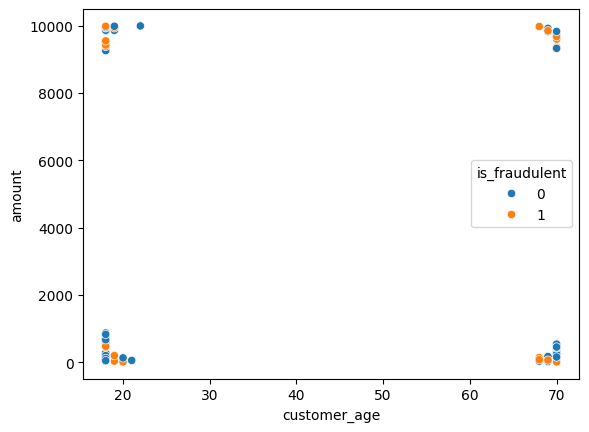

In [39]:
sns.scatterplot(x='customer_age', y='amount', hue='is_fraudulent', data=filtered_df)

De manera visual, vemos donde están los casos que se presentan como 100% outliers. Tenemos gastos tanto alto como bajos, edades máximas y mínimas en cada esquina y no hay exclusividad de que sea fraudulento.

In [40]:
filtered_df[(filtered_df['is_fraudulent'] == 1) & (filtered_df['customer_age'] > 50)]

transaction_id customer_id merchant_id   amount is_fraudulent  \
367             368        1024        2041   153.30             1   
621             622        1057        2084  9708.95             1   
655             656        1074        2084  9898.77             1   
843             844        1100        2064   240.04             1   
1246           1247        1050        2041   498.63             1   
2810           2811        1099        2015  9367.16             1   
3031           3032        1008        2052  9601.54             1   
3452           3453        1078        2002  9676.94             1   
3487           3488        1020        2061    14.24             1   
4323           4324        1060        2070   140.35             1   
4537           4538        1024        2002    38.83             1   
5032           5033        1017        2051  9851.05             1   
5543           5544        1047        2085   445.66             1   
5580           5581        1044        2023  9325.05             1   
7333           7334        1074        2037  9977.94             1   
8521           8522        1069        2012    69.32             1   
8962           8963        1023        2024    78.42             1   

             card_type location purchase_category  customer_age  \
367               Visa  City-21       Gas Station            70   
621         MasterCard  City-18            Retail            70   
655   American Express  City-13   Online Shopping            69   
843         MasterCard  City-27         Groceries            70   
1246          Discover  City-28        Restaurant            70   
2810          Discover  City-15            Retail            70   
3031        MasterCard  City-45            Retail            70   
3452          Discover  City-10       Gas Station            70   
3487        MasterCard   City-6            Travel            70   
4323  American Express  City-41        Restaurant            68   
4537          Discover  City-46            Retail            69   
5032              Visa   City-1       Gas Station            69   
5543        MasterCard  City-11         Groceries            70   
5580          Discover  City-19            Travel            70   
7333              Visa  City-27       Gas Station            68   
8521          Discover  City-23            Retail            69   
8962        MasterCard  City-16            Retail            68   

      outliers_ifo_0.01_100  outliers_ifo_0.01_500  outliers_ifo_0.01_1000  \
367                      -1                     -1                      -1   
621                      -1                     -1                      -1   
655                      -1                     -1                      -1   
843                      -1                     -1                      -1   
1246                     -1                     -1                      -1   
2810                     -1                     -1                      -1   
3031                     -1                     -1                      -1   
3452                     -1                     -1                      -1   
3487                     -1                     -1                      -1   
4323                     -1                     -1                      -1   
4537                     -1                     -1                      -1   
5032                     -1                     -1                      -1   
5543                     -1                     -1                      -1   
5580                     -1                     -1                      -1   
7333                     -1                     -1                      -1   
8521                     -1                     -1                      -1   
8962                     -1                     -1                      -1   

      outliers_ifo_0.05_100  outliers_ifo_0.05_500  outliers_ifo_0.05_1000  \
367                      -1                     -1    

In [41]:
filtered_df[(filtered_df['is_fraudulent'] == 0) & (filtered_df['customer_age'] > 50)]

transaction_id customer_id merchant_id   amount is_fraudulent  \
295             296        1084        2061  9677.67             0   
345             346        1063        2012   544.84             0   
1184           1185        1033        2073   404.74             0   
1270           1271        1062        2071   429.83             0   
1857           1858        1046        2056   309.30             0   
3018           3019        1092        2062  9921.86             0   
3197           3198        1033        2090   548.29             0   
3333           3334        1086        2032  9732.66             0   
3964           3965        1042        2074   164.11             0   
4195           4196        1083        2017   540.20             0   
4285           4286        1054        2073  9825.85             0   
5066           5067        1078        2015   244.95             0   
5745           5746        1070        2065   176.20             0   
6295           6296        1090        2045   438.11             0   
6633           6634        1048        2069    29.76             0   
6667           6668        1039        2027   456.85             0   
6867           6868        1032        2061   160.30             0   
8384           8385        1032        2049    36.90             0   
9011           9012        1032        2014  9831.36             0   
9429           9430        1032        2086  9328.91             0   

             card_type location purchase_category  customer_age  \
295           Discover  City-31   Online Shopping            70   
345   American Express  City-13         Groceries            70   
1184        MasterCard  City-15            Retail            70   
1270          Discover   City-2            Retail            70   
1857        MasterCard  City-29            Travel            70   
3018        MasterCard  City-48            Travel            69   
3197              Visa  City-47   Online Shopping            70   
3333              Visa  City-32   Online Shopping            70   
3964              Visa  City-30   Online Shopping            70   
4195        MasterCard   City-7            Retail            70   
4285  American Express   City-1            Travel            69   
5066  American Express  City-12            Retail            70   
5745          Discover  City-15            Retail            69   
6295        MasterCard  City-40            Retail            70   
6633        MasterCard  City-49         Groceries            69   
6667              Visa  City-23        Restaurant            70   
6867              Visa  City-22   Online Shopping            70   
8384        MasterCard  City-10        Restaurant            68   
9011  American Express  City-14   Online Shopping            70   
9429  American Express  City-24            Retail            70   

      outliers_ifo_0.01_100  outliers_ifo_0.01_500  outliers_ifo_0.01_1000  \
295                      -1                     -1                      -1   
345                      -1                     -1                      -1   
1184                     -1                     -1                      -1   
1270                     -1                     -1                      -1   
1857                     -1                     -1                      -1   
3018                     -1                     -1                      -1   
3197                     -1                     -1                      -1   
3333                     -1                     -1                      -1   
3964                     -1                     -1                      -1   
4195                     -1                     -1                      -1   
4285                     -1                     -1                      -1   
5066                     -1                     -1                      -1   
5745                     -1                     -1                      -1   
6295                     -1       

In [42]:
filtered_df[(filtered_df['is_fraudulent'] == 1) & (filtered_df['customer_age'] < 21)]

transaction_id customer_id merchant_id   amount is_fraudulent  \
1108           1109        1019        2076   232.03             1   
1582           1583        1017        2080    38.15             1   
1612           1613        1003        2033   605.33             1   
2643           2644        1071        2002   805.27             1   
3083           3084        1094        2006  9945.73             1   
3102           3103        1025        2085  9352.34             1   
3878           3879        1028        2046   307.71             1   
4240           4241        1043        2034  9405.56             1   
4706           4707        1070        2017    89.11             1   
5152           5153        1016        2100  9448.05             1   
5311           5312        1085        2018   229.45             1   
5784           5785        1079        2025    48.43             1   
5858           5859        1022        2027    16.31             1   
6332           6333        1084        2074  9385.46             1   
6928           6929        1044        2025   446.99             1   
7109           7110        1053        2045   478.04             1   
7239           7240        1003        2022  9936.55             1   
8553           8554        1002        2029  9428.15             1   
8681           8682        1029        2068  9938.26             1   
8702           8703        1011        2082  9982.93             1   
8739           8740        1083        2053   715.32             1   
8778           8779        1002        2068  9549.87             1   
8995           8996        1074        2026   208.60             1   
9794           9795        1049        2032   200.80             1   

             card_type location purchase_category  customer_age  \
1108          Discover  City-44        Restaurant            18   
1582  American Express  City-29            Retail            19   
1612  American Express  City-46            Travel            18   
2643          Discover  City-35            Retail            18   
3083          Discover  City-10            Travel            19   
3102        MasterCard   City-6         Groceries            18   
3878        MasterCard  City-22            Retail            18   
4240        MasterCard   City-7         Groceries            18   
4706              Visa  City-37   Online Shopping            18   
5152          Discover  City-23         Groceries            18   
5311  American Express  City-30            Travel            18   
5784        MasterCard  City-24            Retail            18   
5858          Discover   City-1        Restaurant            20   
6332        MasterCard  City-15   Online Shopping            18   
6928        MasterCard  City-47   Online Shopping            18   
7109  American Express   City-6         Groceries            18   
7239              Visa  City-26            Travel            18   
8553  American Express  City-38        Restaurant            18   
8681          Discover   City-4   Online Shopping            19   
8702        MasterCard  City-35   Online Shopping            18   
8739  American Express  City-26   Online Shopping            18   
8778          Discover  City-45        Restaurant            18   
8995        MasterCard  City-33       Gas Station            19   
9794              Visa   City-5        Restaurant            19   

      outliers_ifo_0.01_100  outliers_ifo_0.01_500  outliers_ifo_0.01_1000  \
1108                     -1                     -1                      -1   
1582                     -1                     -1                      -1   
1612                     -1                     -1                      -1   
2643                     -1                     -1                      -1   
3083                     -1                     -1                      -1   
3102                     -1                     -1                      -1   
3878                     -1     

Me parece que como tal, casos a eliminar o declarar 100% outliers son aquellos que presentan montos excesivos para la edad (18-19) de algunos grupos, particularmente cuando se dan en casos como retail, online shopping o restaurant. 

Así mismo, en el caso de situaciones de adultos mayores (Edad > 65) donde hacen gastos en retail o online shopping de montos altos.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   transaction_id          10000 non-null  category
 1   customer_id             10000 non-null  category
 2   merchant_id             10000 non-null  category
 3   amount                  10000 non-null  float64 
 4   is_fraudulent           10000 non-null  category
 5   card_type               10000 non-null  object  
 6   location                10000 non-null  object  
 7   purchase_category       10000 non-null  object  
 8   customer_age            10000 non-null  int64   
 9   outliers_ifo_0.01_100   10000 non-null  int32   
 10  outliers_ifo_0.01_500   10000 non-null  int32   
 11  outliers_ifo_0.01_1000  10000 non-null  int32   
 12  outliers_ifo_0.05_100   10000 non-null  int32   
 13  outliers_ifo_0.05_500   10000 non-null  int32   
 14  outliers_ifo_0.05_1000 

In [44]:
fragmento = 0.6 * len(columnas_ifo)
df_fragmento_60 = df[df[columnas_ifo].eq(-1).sum(axis=1) >= fragmento]

In [45]:
df_fragmento_60

transaction_id customer_id merchant_id   amount is_fraudulent  \
17               18        1004        2040    79.76             0   
165             166        1088        2009  9567.11             1   
176             177        1038        2098  8848.87             1   
191             192        1082        2074  9929.87             1   
204             205        1042        2053   179.39             0   
...             ...         ...         ...      ...           ...   
9892           9893        1049        2005   396.14             1   
9938           9939        1068        2093  9963.62             0   
9941           9942        1027        2044  8675.64             1   
9965           9966        1091        2056  9640.20             0   
9973           9974        1060        2042  9987.57             1   

             card_type location purchase_category  customer_age  \
17                Visa  City-17        Restaurant            64   
165           Discover  City-45            Retail            20   
176   American Express  City-27            Retail            18   
191   American Express  City-48         Groceries            22   
204   American Express  City-14            Travel            66   
...                ...      ...               ...           ...   
9892        MasterCard   City-8       Gas Station            20   
9938  American Express  City-19         Groceries            29   
9941          Discover  City-39         Groceries            70   
9965          Discover  City-34         Groceries            68   
9973          Discover  City-33            Travel            62   

      outliers_ifo_0.01_100  outliers_ifo_0.01_500  outliers_ifo_0.01_1000  \
17                        1                      1                       1   
165                       1                      1                       1   
176                       1                      1                       1   
191                       1                      1                       1   
204                       1                      1                       1   
...                     ...                    ...                     ...   
9892                      1                      1                       1   
9938                      1                      1                       1   
9941                      1                      1                       1   
9965                      1                      1                       1   
9973                      1                      1                       1   

      outliers_ifo_0.05_100  outliers_ifo_0.05_500  outliers_ifo_0.05_1000  \
17                       -1                     -1                      -1   
165                      -1                     -1                      -1   
176                      -1                     -1                      -1   
191                      -1                     -1                      -1   
204                      -1                     -1                      -1   
...                     ...                    ...                     ...   
9892                     -1                     -1                      -1   
9938                     -1                     -1                      -1   
9941                     -1                     -1                      -1   
9965                     -1                     -1                      -1   
9973                     -1                     -1                      -1   

      outliers_ifo_0.1_100  outliers_ifo_0.1_500  outliers_ifo_0.1_1000  
17                      -1                    -1                     -1  
165                     -1                    -1                     -1  
176                     -1                    -1                     -1  
191                     -1                    -1                     -1  
204                     -1                    -1                     -1  
...                    ...               

## Nuevamente EDA - Después de limpiar

## Pendiente de eliminar outliers

In [46]:
df.drop(columns=columnas_ifo, inplace=True)

In [47]:
df.head()

transaction_id customer_id merchant_id   amount is_fraudulent   card_type  \
0              1        1082        2027  5758.59             0  MasterCard   
1              2        1015        2053  1901.56             1        Visa   
2              3        1004        2035  1248.86             1  MasterCard   
3              4        1095        2037  7619.05             1    Discover   
4              5        1036        2083  1890.10             1  MasterCard   

  location purchase_category  customer_age  
0  City-30       Gas Station            43  
1  City-47   Online Shopping            61  
2   City-6       Gas Station            57  
3   City-6            Travel            59  
4  City-34            Retail            36

# Método para ver si hay diferencias (chi-cuadrados) en las categóricas:

In [48]:
f.detectar_orden_cat(df, lista_cat=df.select_dtypes(include=['object', 'category']), var_respuesta='is_fraudulent')

Estamos evaluando la variable TRANSACTION_ID


is_fraudulent   0  1
transaction_id      
1               1  0
2               0  1
3               0  1
4               0  1
5               0  1
...            .. ..
9996            0  1
9997            1  0
9998            1  0
9999            0  1
10000           0  1

[10000 rows x 2 columns]

La variable transaction_id no tiene orden
Estamos evaluando la variable CUSTOMER_ID


is_fraudulent   0   1
customer_id          
1001           44  42
1002           45  45
1003           37  44
1004           36  51
1005           47  45
...            ..  ..
1096           46  52
1097           45  50
1098           46  58
1099           60  56
1100           54  49

[100 rows x 2 columns]

La variable customer_id no tiene orden
Estamos evaluando la variable MERCHANT_ID


is_fraudulent   0   1
merchant_id          
2001           45  42
2002           59  52
2003           46  54
2004           49  52
2005           38  51
...            ..  ..
2096           59  48
2097           53  46
2098           44  52
2099           58  55
2100           29  46

[100 rows x 2 columns]

La variable merchant_id no tiene orden
Estamos evaluando la variable IS_FRAUDULENT


is_fraudulent     0     1
is_fraudulent            
0              4932     0
1                 0  5068

Sí tiene orden la variable is_fraudulent
Estamos evaluando la variable CARD_TYPE


is_fraudulent        0     1
card_type                   
American Express  1262  1232
Discover          1304  1329
MasterCard        1140  1243
Visa              1226  1264

La variable card_type no tiene orden
Estamos evaluando la variable LOCATION


is_fraudulent    0    1
location               
City-1          80  108
City-10        100   94
City-11         92  107
City-12        102  107
City-13         99  110
City-14        106  112
City-15         96   88
City-16         92   94
City-17        109   96
City-18         89  105
City-19        103   98
City-2          97   88
City-20        102  113
City-21         92   99
City-22        119   94
City-23         95  114
City-24        114  103
City-25        104  103
City-26         83  109
City-27         95   96
City-28         95  112
City-29         94  103
City-3          99   96
City-30         96   95
City-31         75  102
City-32        113  105
City-33         97   99
City-34         96   95
City-35         71   87
City-36         90   77
City-37        106  103
City-38         99   92
City-39        105  104
City-4         121   92
City-40        112  109
City-41        103  115
City-42        105  101
City-43        115   95
City-44         82  107
City-45        116   95
City-46        108   88
City-47         97  109
City-48         87  115
City-49        106   96
City-5          99  111
City-50         98  104
City-6          76  114
City-7         103  120
City-8          89   99
City-9         110   90

La variable location no tiene orden
Estamos evaluando la variable PURCHASE_CATEGORY


is_fraudulent        0    1
purchase_category          
Gas Station        792  874
Groceries          796  896
Online Shopping    847  804
Restaurant         851  785
Retail             808  853
Travel             838  856

Sí tiene orden la variable purchase_category


Observaciones del chi_cuadrado:
- transaction_id no tiene orden.
- customer_id no tiene orden.
- merchant_id no tiene orden.
- card_type no tiene orden.
- location no tiene orden.
- purchase_category tiene orden.

* Al no haber diferencias entre variables, implica que debemos recurrir a métodos como el one hot encoding o get dumies. Pero en estos casos, nuestras variables pueden aportar una inmensa cantidad de columnas nuevas. Por ende pasaré a codificar utilizando algún método ordinal.

In [49]:
df.head()

transaction_id customer_id merchant_id   amount is_fraudulent   card_type  \
0              1        1082        2027  5758.59             0  MasterCard   
1              2        1015        2053  1901.56             1        Visa   
2              3        1004        2035  1248.86             1  MasterCard   
3              4        1095        2037  7619.05             1    Discover   
4              5        1036        2083  1890.10             1  MasterCard   

  location purchase_category  customer_age  
0  City-30       Gas Station            43  
1  City-47   Online Shopping            61  
2   City-6       Gas Station            57  
3   City-6            Travel            59  
4  City-34            Retail            36

## Estandarizar

In [50]:
escalador_robust = RobustScaler()
datos_transf_robust = escalador_robust.fit_transform(df[["amount", 'customer_age']])
df[["amount_robust", 'customer_age_robust']] = datos_transf_robust

escalador_min_max = MinMaxScaler()
datos_transf_min_max = escalador_min_max.fit_transform(df[["amount", 'customer_age']])
df[["amount_minmax", 'customer_age_minmax']] = datos_transf_min_max

escalador_norm = Normalizer()
datos_transf_norm = escalador_norm.fit_transform(df[["amount", 'customer_age']])
df[["amount_norm", 'customer_age_norm']] = datos_transf_norm

escalador_stand = StandardScaler()
datos_transf_stand = escalador_stand.fit_transform(df[["amount", 'customer_age']])
df[["amount_stand", 'customer_age_stand']] = datos_transf_stand

In [51]:
df['amount'].agg(['mean', 'median'])

mean      4958.381617
median    4943.945000
Name: amount, dtype: float64

In [52]:
df['customer_age'].agg(['mean', 'median'])

mean      44.0475
median    44.0000
Name: customer_age, dtype: float64

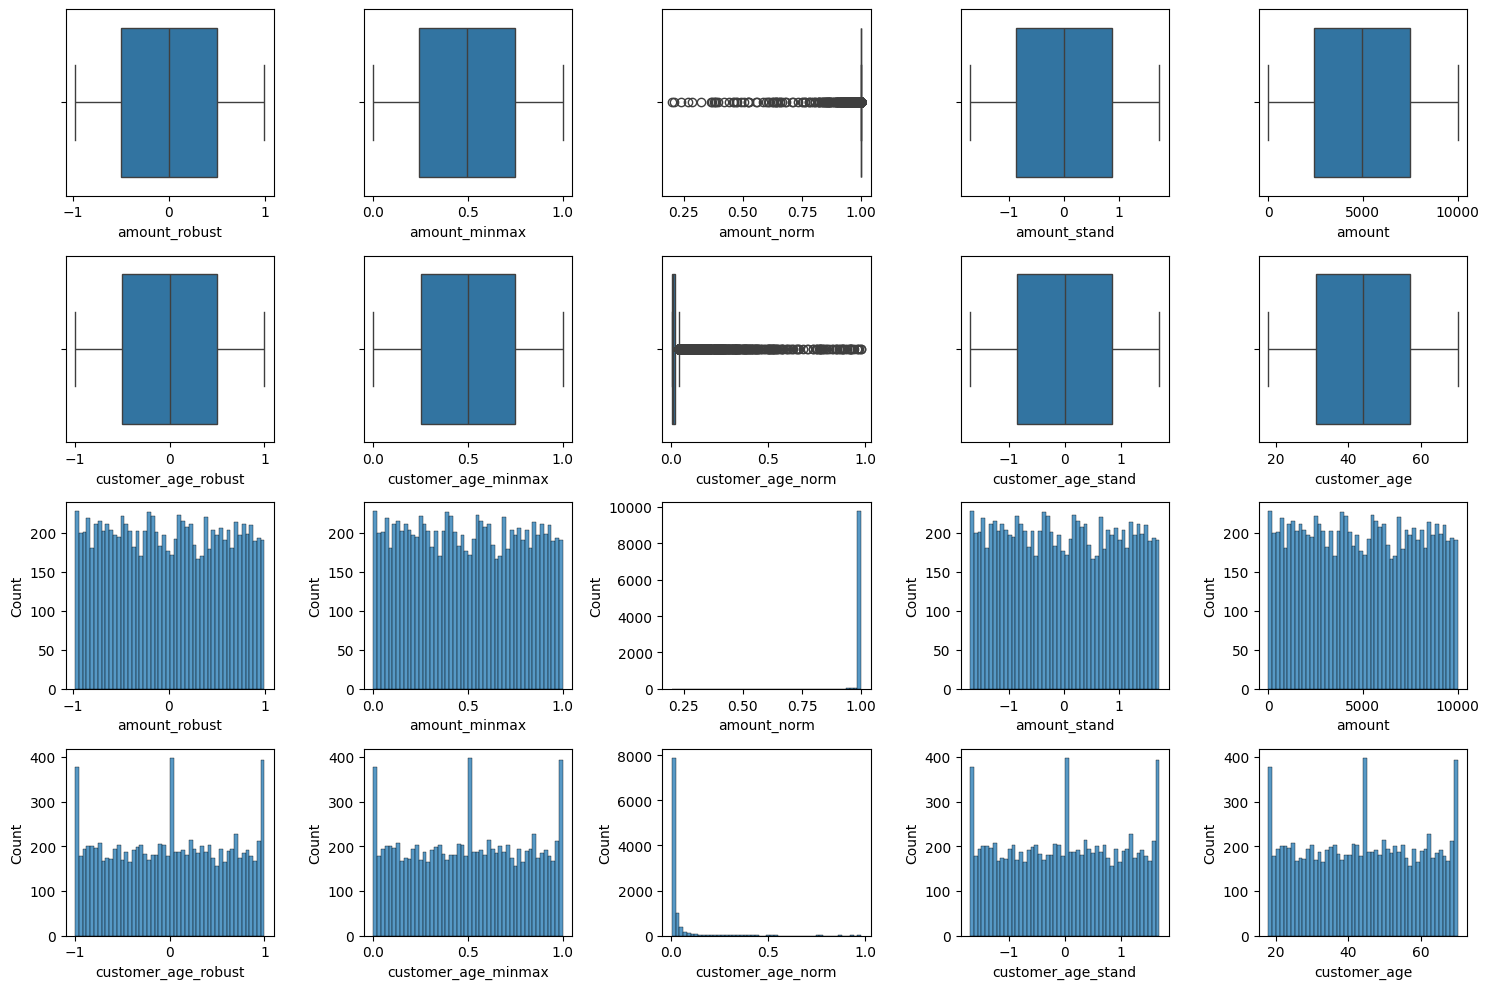

In [53]:
fig , axes = plt.subplots(nrows=4 , ncols=5, figsize = (15, 10))
sns.boxplot(x = "amount_robust", data = df, ax = axes[0][0])
sns.boxplot(x = "amount_minmax", data = df, ax = axes[0][1])
sns.boxplot(x = "amount_norm", data = df, ax = axes[0][2])
sns.boxplot(x = "amount_stand", data = df, ax = axes[0][3])
sns.boxplot(x = "amount", data = df, ax = axes[0][4])

sns.boxplot(x = "customer_age_robust", data = df, ax = axes[1][0])
sns.boxplot(x = "customer_age_minmax", data = df, ax = axes[1][1])
sns.boxplot(x = "customer_age_norm", data = df, ax = axes[1][2])
sns.boxplot(x = "customer_age_stand", data = df, ax = axes[1][3])
sns.boxplot(x = "customer_age", data = df, ax = axes[1][4])

sns.histplot(x = "amount_robust", data = df, ax = axes[2][0], bins = 50)
sns.histplot(x = "amount_minmax", data = df, ax = axes[2][1], bins = 50)
sns.histplot(x = "amount_norm", data = df, ax = axes[2][2], bins = 50)
sns.histplot(x = "amount_stand", data = df, ax = axes[2][3], bins = 50)
sns.histplot(x = "amount", data = df, ax = axes[2][4], bins = 50)


sns.histplot(x = "customer_age_robust", data = df, ax = axes[3][0], bins = 50)
sns.histplot(x = "customer_age_minmax", data = df, ax = axes[3][1], bins = 50)
sns.histplot(x = "customer_age_norm", data = df, ax = axes[3][2], bins = 50)
sns.histplot(x = "customer_age_stand", data = df, ax = axes[3][3], bins = 50)
sns.histplot(x = "customer_age", data = df, ax = axes[3][4], bins = 50)

plt.tight_layout()

Con estas visualizaciones, pienso quedarme con el modelo Min-Max. Porque es un método para aquellos que aparentan normalidad, o normalidad perfecta. Además de que estas variables no tienen outliers como tal.

In [54]:
df.describe()

amount  customer_age  amount_robust  customer_age_robust  \
count  10000.000000  10000.000000   1.000000e+04         10000.000000   
mean    4958.381617     44.047500   2.852445e-03             0.001827   
std     2899.699675     15.321707   5.729344e-01             0.589296   
min       10.610000     18.000000  -9.747483e-01            -1.000000   
25%     2438.175000     31.000000  -4.951002e-01            -0.500000   
50%     4943.945000     44.000000   8.985326e-17             0.000000   
75%     7499.312500     57.000000   5.048998e-01             0.500000   
max     9999.750000     70.000000   9.989464e-01             1.000000   

       amount_minmax  customer_age_minmax   amount_norm  customer_age_norm  \
count   10000.000000         10000.000000  10000.000000       10000.000000   
mean        0.495315             0.500913      0.996068           0.026985   
std         0.290285             0.294648      0.035761           0.076430   
min         0.000000             0.000000      0.199346           0.001803   
25%         0.243020             0.250000      0.999836           0.005586   
50%         0.493870             0.500000      0.999960           0.008890   
75%         0.749684             0.750000      0.999984           0.018086   
max         1.000000             1.000000      0.999998           0.979929   

       amount_stand  customer_age_stand  
count  1.000000e+04        1.000000e+04  
mean  -7.105427e-19        2.842171e-17  
std    1.000050e+00        1.000050e+00  
min   -1.706390e+00       -1.700124e+00  
25%   -8.691702e-01       -8.516122e-01  
50%   -4.978908e-03       -3.100332e-03  
75%    8.763176e-01        8.454115e-01  
max    1.738670e+00        1.693923e+00

In [55]:
df.head()

transaction_id customer_id merchant_id   amount is_fraudulent   card_type  \
0              1        1082        2027  5758.59             0  MasterCard   
1              2        1015        2053  1901.56             1        Visa   
2              3        1004        2035  1248.86             1  MasterCard   
3              4        1095        2037  7619.05             1    Discover   
4              5        1036        2083  1890.10             1  MasterCard   

  location purchase_category  customer_age  amount_robust  \
0  City-30       Gas Station            43       0.160961   
1  City-47   Online Shopping            61      -0.601127   
2   City-6       Gas Station            57      -0.730090   
3   City-6            Travel            59       0.528558   
4  City-34            Retail            36      -0.603391   

   customer_age_robust  amount_minmax  customer_age_minmax  amount_norm  \
0            -0.038462       0.575423             0.480769     0.999972   
1             0.653846       0.189301             0.826923     0.999486   
2             0.500000       0.123960             0.750000     0.998960   
3             0.576923       0.761671             0.788462     0.999970   
4            -0.307692       0.188153             0.346154     0.999819   

   customer_age_norm  amount_stand  customer_age_stand  
0           0.007467      0.275976           -0.068370  
1           0.032062     -1.054238            1.106492  
2           0.045594     -1.279342            0.845411  
3           0.007744      0.917613            0.975952  
4           0.019043     -1.058191           -0.525261

In [56]:
columnas_seleccionadas = ['transaction_id', 'customer_id', 'merchant_id', 'amount_minmax', 'is_fraudulent', 'card_type', 'location' , 'purchase_category' ,'customer_age_minmax']

In [57]:
df = df[columnas_seleccionadas]

## Encoding

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   transaction_id       10000 non-null  category
 1   customer_id          10000 non-null  category
 2   merchant_id          10000 non-null  category
 3   amount_minmax        10000 non-null  float64 
 4   is_fraudulent        10000 non-null  category
 5   card_type            10000 non-null  object  
 6   location             10000 non-null  object  
 7   purchase_category    10000 non-null  object  
 8   customer_age_minmax  10000 non-null  float64 
dtypes: category(4), float64(2), object(3)
memory usage: 785.6+ KB


In [59]:
df['is_fraudulent'] = df['is_fraudulent'].astype(int)
df['card_type'] = df['card_type'].astype('category')
df['location'] = df['location'].astype('category')
df['purchase_category'] = df['purchase_category'].astype('category')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   transaction_id       10000 non-null  category
 1   customer_id          10000 non-null  category
 2   merchant_id          10000 non-null  category
 3   amount_minmax        10000 non-null  float64 
 4   is_fraudulent        10000 non-null  int32   
 5   card_type            10000 non-null  category
 6   location             10000 non-null  category
 7   purchase_category    10000 non-null  category
 8   customer_age_minmax  10000 non-null  float64 
dtypes: category(6), float64(2), int32(1)
memory usage: 612.5 KB


In [61]:
df = df.drop(columns=['transaction_id', 'customer_id', 'merchant_id'])

In [62]:
diccionario_encoding = { "target": ['purchase_category'] , 
                        "onehot": ["card_type", "location"]} 
# En caso de que queramos aplicar el método solo a una columna
encoding = se.Encoding(df, variable_respuesta="is_fraudulent", diccionario_encoding=diccionario_encoding)
df = encoding.one_hot_encoding()
df = encoding.target_encoding()
df.head()

['purchase_category']


amount_minmax  is_fraudulent  purchase_category  customer_age_minmax  \
0       0.575423              0           0.524610             0.480769   
1       0.189301              1           0.486978             0.826923   
2       0.123960              1           0.524610             0.750000   
3       0.761671              1           0.505313             0.788462   
4       0.188153              1           0.513546             0.346154   

   card_type_American Express  card_type_Discover  card_type_MasterCard  \
0                         0.0                 0.0                   1.0   
1                         0.0                 0.0                   0.0   
2                         0.0                 0.0                   1.0   
3                         0.0                 1.0                   0.0   
4                         0.0                 0.0                   1.0   

   card_type_Visa  location_City-1  location_City-10  location_City-11  \
0             0.0              0.0               0.0               0.0   
1             1.0              0.0               0.0               0.0   
2             0.0              0.0               0.0               0.0   
3             0.0              0.0               0.0               0.0   
4             0.0              0.0               0.0               0.0   

   location_City-12  location_City-13  location_City-14  location_City-15  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   location_City-16  location_City-17  location_City-18  location_City-19  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   location_City-2  location_City-20  location_City-21  location_City-22  \
0              0.0               0.0               0.0               0.0   
1              0.0               0.0               0.0               0.0   
2              0.0               0.0               0.0               0.0   
3              0.0               0.0               0.0               0.0   
4              0.0               0.0               0.0               0.0   

   location_City-23  location_City-24  location_City-25  location_City-26  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   location_City-27  location_City-28  location_City-29  location_City-3  \
0               0.0               0.0               0.0              0.0   
1               0.0               0.0               0.0              0.0   
2               0.0               0.0               0.0              0.0   
3               0.0               0.0               0.0              0.0   
4               0.0               0.0               0.0              0.0   

   location_City-30  location_City-31  location_City-32  location_City-33  \
0               1.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0        

In [63]:
df.shape

(10000, 58)

In [64]:
df.to_pickle('datos/datos_pt2.pkl')